<a href="https://colab.research.google.com/github/jjossie/jbeds-road-signs/blob/main/Final_David.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test_partial.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test_classes_partial.csv

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/test.zip
!unzip -q /content/test_partial.zip

# Combine the two traning directories
!echo "Merging training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm test.zip
!rm test_partial.zip

!echo "Data ready."

Unzipping files...
Merging training data...
Cleaning up...
Data ready.


In [ ]:
import os
import shutil

# Source folder path containing the training images
source_folder = "/content/training/00000"

# Destination folder path to store the selected 30 images
destination_folder = "/content/video_images"

# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Get the list of files in the source folder
file_list = os.listdir(source_folder)

# Sort the file list if necessary to ensure correct ordering
file_list.sort()

# Select the first 30 files
selected_files = file_list[:30]

# Copy the selected files to the destination folder
for file_name in selected_files:
    source_file_path = os.path.join(source_folder, file_name)
    destination_file_path = os.path.join(destination_folder, file_name)
    shutil.copy(source_file_path, destination_file_path)

In [ ]:
import cv2
import os

# Path to the directory containing the selected images
image_directory = "/content/video_images"

# Get the list of image filenames
image_filenames = os.listdir(image_directory)

# Sort the image filenames if necessary to ensure correct ordering
image_filenames.sort()

# Read the first image to retrieve its size
first_image_path = os.path.join(image_directory, image_filenames[0])
first_image = cv2.imread(first_image_path)
frame_height, frame_width, _ = first_image.shape

# Create a VideoWriter object
output_video_path = "/content/output_video.mp4"  # Replace with the desired output video path
fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Video codec
fps = 30  # Frames per second
frame_size = (frame_width, frame_height)  # Use the size of the first image
video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, frame_size)

# Iterate over the image filenames and add frames to the video
for image_filename in image_filenames:
    image_path = os.path.join(image_directory, image_filename)
    frame = cv2.imread(image_path)

    # Write the frame to the video
    video_writer.write(frame)

# Release the VideoWriter and close the video file
video_writer.release()

print("Video saved successfully.")




Video saved successfully.


In [ ]:
!pip install -q imageio
!pip install -q imageio-ffmpeg


In [ ]:
import cv2
import imageio
output_gif_path = "/content/output_video.gif"  # Replace with the desired output GIF path

# Read the video frames using OpenCV
video = cv2.VideoCapture(output_video_path)

# Create an empty list to store the frames
frames = []

# Iterate over the video frames and append them to the list
while True:
    ret, frame = video.read()
    if not ret:
        break
    frames.append(frame)

# Save the frames as a GIF using imageio
imageio.mimsave(output_gif_path, frames)

print("GIF saved successfully.")

GIF saved successfully.


In [ ]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
from keras.applications import VGG16
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [ ]:
import os
import shutil
from keras.preprocessing.image import ImageDataGenerator
import cv2

# Path to the directory containing the class folders in the training dataset
training_directory = '/content/training/'  # Replace with the actual path to your training dataset directory

# Parameters
num_frames_to_split = 30  # Set the number of frames to split from each class folder
image_size = (100, 100)
batch_size = 32



# Create the test generator by splitting the first 'num_frames_to_split' frames from each class folder
test_directory = '/content/my_test/'  # Replace with the desired path for the test dataset directory
test_datagen = ImageDataGenerator(rescale=1./255)

# Iterate over the class folders in the training dataset
for class_folder in os.listdir(training_directory):
    class_folder_path = os.path.join(training_directory, class_folder)

    if not os.path.isdir(class_folder_path):
        continue  # Skip non-directory files

    # Create the target directory for the test dataset class folder
    test_class_directory = os.path.join(test_directory, class_folder)
    os.makedirs(test_class_directory, exist_ok=True)

    # Get the list of frame filenames in the class folder
    frame_filenames = os.listdir(class_folder_path)

    # Sort the frame filenames if necessary to ensure correct ordering
    frame_filenames.sort()

    # Move the first 'num_frames_to_split' frames to the test dataset class folder
    for frame_filename in frame_filenames[-num_frames_to_split:]:
        frame_path = os.path.join(class_folder_path, frame_filename)
        target_path = os.path.join(test_class_directory, frame_filename)
        shutil.move(frame_path, target_path)

# Create the test generator
test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Create the training generator
def preprocess_image(img):
    # Randomly select transformations to apply
    do_blur = np.random.rand() < 0.1  # 10% chance of applying blur
    do_grayscale = np.random.rand() < 0.5  # 50% chance of applying grayscale

    # Apply transformations based on conditions
    if do_blur:
        img = cv2.GaussianBlur(img, (7, 7), 10)

    #if do_grayscale:
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    return img


train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2,
        rotation_range = 10, #Degrees to either side, test set doesn't seem too varied
        height_shift_range = 0.05, # % change up or down
        width_shift_range = .1, # # change left or right
        zoom_range = .2, # also little variation
        brightness_range = (0,1), #biggest impact, keep high
        fill_mode = "reflect", #when we move the image, what replaces the old location spot
        preprocessing_function=preprocess_image,
        )

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Create the training generator
train_generator = train_datagen.flow_from_directory(
    training_directory,
    target_size=image_size,
    subset="training",
    batch_size=batch_size,
    class_mode='categorical',
    seed=42,
    shuffle=True
)

# Create the validation generator
validation_generator = validation_datagen.flow_from_directory(
    training_directory,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset="validation",
    seed=42,
    shuffle=False
)

print("Training, validation, and test generators created successfully.")


Found 1290 images belonging to 43 classes.
Found 30336 images belonging to 43 classes.
Found 7583 images belonging to 43 classes.
Training, validation, and test generators created successfully.


In [ ]:
# We're using keras' ImageDataGenerator class to load our image data.
# See (https://keras.io/api/preprocessing/image/#imagedatagenerator-class) for details
#
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation.


training_dir = '/content/training/'
image_size = (100, 100)

# Split up the training data images into training and validations sets
# We'll use and ImageDataGenerator to do the splits
# ImageDataGenerator can also be used to do preprocessing and agumentation on the files as can be seen with rescale

train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size = image_size,
        subset="training",
        batch_size=32,
        class_mode='categorical',
        seed=42,shuffle=True)
validation_generator = validation_datagen.flow_from_directory(
        training_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='categorical',
        subset="validation",
        seed=42,
        shuffle=False)



Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


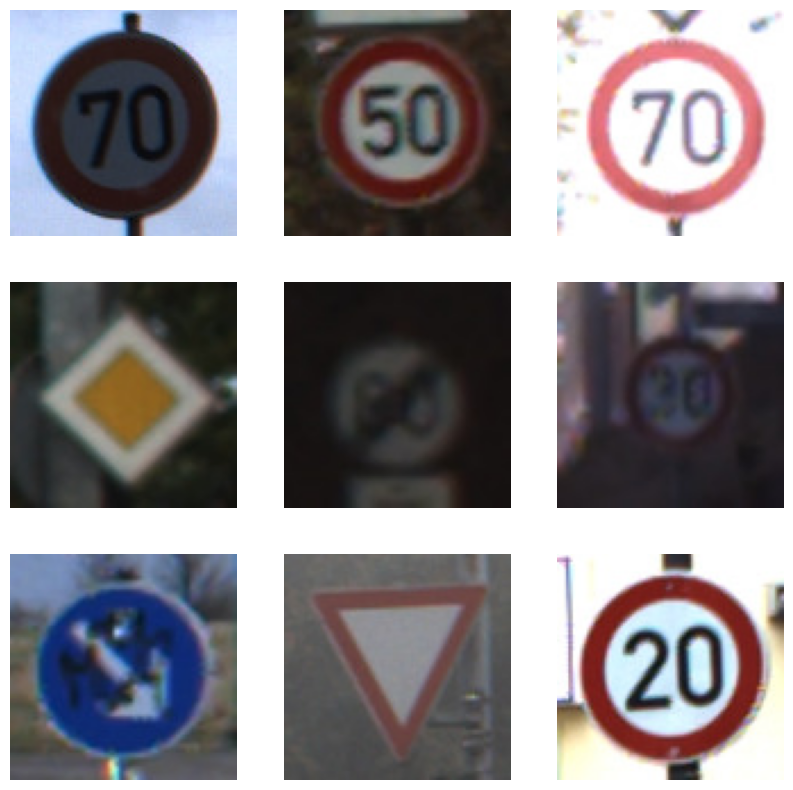

In [ ]:
# View 9 images and their class labels
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(9):
        first_image = images[i]
        ax = plt.subplot(3, 3, i + 1)
        f = np.array(first_image) * 255
        plt.imshow(f.astype("uint8"))
        plt.axis("off")
    break

In [ ]:
# Load the pre-trained inception model (excluding the top layer)

from keras import datasets, layers, models
inception = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(100,100,3)
)

# Create your CNN model based on VGG16
model = Sequential()
model.add(inception)
model.add(Flatten())
model.add(Dense(43, activation='softmax'))  # 43 is the number of classes in this example

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the generator
training_history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size
        )

87910968/87910968 [==============================] - 5s 0us/step
Epoch 1/10
948/948 [==============================] - 210s 169ms/step - loss: 0.7163 - accuracy: 0.8106 - val_loss: 0.8491 - val_accuracy: 0.9081
Epoch 2/10
948/948 [==============================] - 158s 166ms/step - loss: 0.1950 - accuracy: 0.9491 - val_loss: 0.0629 - val_accuracy: 0.9852
Epoch 3/10
948/948 [==============================] - 157s 166ms/step - loss: 0.1425 - accuracy: 0.9629 - val_loss: 0.1129 - val_accuracy: 0.9680
Epoch 4/10
948/948 [==============================] - 155s 163ms/step - loss: 0.1234 - accuracy: 0.9671 - val_loss: 0.6811 - val_accuracy: 0.9223
Epoch 5/10
948/948 [==============================] - 157s 166ms/step - loss: 0.1216 - accuracy: 0.9676 - val_loss: 0.1360 - val_accuracy: 0.9735
Epoch 6/10
948/948 [==============================] - 158s 166ms/step - loss: 0.1063 - accuracy: 0.9721 - val_loss: 0.1059 - val_accuracy: 0.9734
Epoch 7/10
948/948 [==============================] - 157s 

In [ ]:
probabilities = model.predict(validation_generator)
predicted_labels = np.argmax(probabilities, axis=1)

true_labels = validation_generator.classes

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)


237/237 [==============================] - 10s 38ms/step
Accuracy: 0.9912963207173942
Precision: 0.9916237839094878
Recall: 0.9912963207173942
F1 Score: 0.9913085857064338


In [ ]:
probabilities = model.predict(test_generator)
predicted_labels = np.argmax(probabilities, axis=1)

true_labels = test_generator.classes

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

41/41 [==============================] - 2s 48ms/step
Accuracy: 0.9961240310077519
Precision: 0.9963428357089272
Recall: 0.9961240310077519
F1 Score: 0.9961203664781637


In [ ]:
from sklearn.metrics import accuracy_score


# Get the unique classes in the dataset
classes = np.unique(true_labels)

# Initialize a dictionary to store the percentage of correctly predicted images for each class
class_percentages = {}

# Iterate over the classes
for cls in classes:
    class_indices = np.where(true_labels == cls)[0]  # Indices of images belonging to the current class
    class_predictions = predicted_labels[class_indices]  # Predicted labels for the current class
    num_correct = np.sum(class_predictions == cls)  # Count the number of correctly predicted images
    num_total = len(class_indices)  # Total number of images in the class
    percentage = (num_correct / num_total) * 100  # Calculate the percentage of correctly predicted images
    class_percentages[cls] = percentage

# Print the percentage of correctly predicted images for each class
for cls, percentage in class_percentages.items():
    print(f"Class {cls}: {percentage:.2f}%")




Class 0: 100.00%
Class 1: 100.00%
Class 2: 100.00%
Class 3: 100.00%
Class 4: 100.00%
Class 5: 96.67%
Class 6: 100.00%
Class 7: 100.00%
Class 8: 100.00%
Class 9: 100.00%
Class 10: 100.00%
Class 11: 100.00%
Class 12: 100.00%
Class 13: 100.00%
Class 14: 100.00%
Class 15: 100.00%
Class 16: 100.00%
Class 17: 100.00%
Class 18: 100.00%
Class 19: 100.00%
Class 20: 100.00%
Class 21: 100.00%
Class 22: 100.00%
Class 23: 100.00%
Class 24: 100.00%
Class 25: 100.00%
Class 26: 93.33%
Class 27: 100.00%
Class 28: 100.00%
Class 29: 100.00%
Class 30: 100.00%
Class 31: 100.00%
Class 32: 100.00%
Class 33: 100.00%
Class 34: 100.00%
Class 35: 100.00%
Class 36: 100.00%
Class 37: 100.00%
Class 38: 100.00%
Class 39: 93.33%
Class 40: 100.00%
Class 41: 100.00%
Class 42: 100.00%


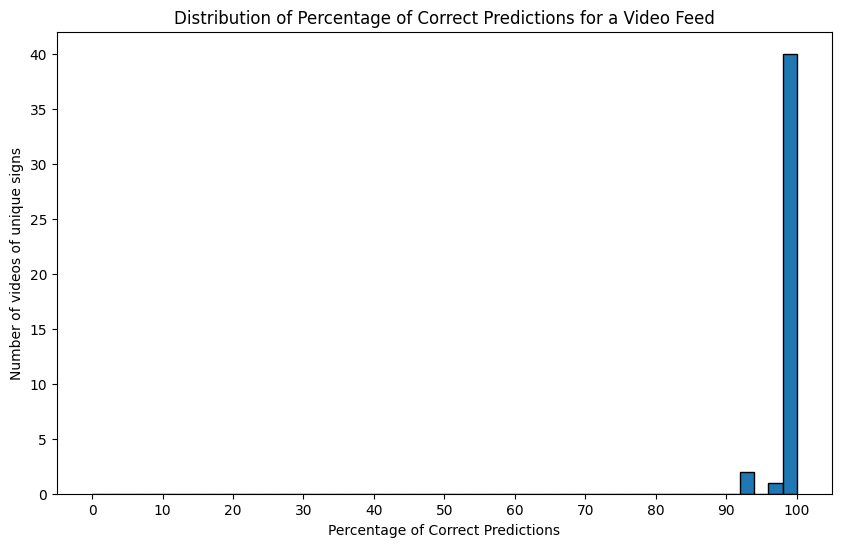

In [ ]:
# Extract the percentages from the dictionary
percentages = list(class_percentages.values())

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(percentages, bins=50, range=(0, 100), edgecolor='black')
plt.xlabel('Percentage of Correct Predictions')
plt.ylabel('Number of videos of unique signs')
plt.title('Distribution of Percentage of Correct Predictions for a Video Feed')
plt.xticks(range(0, 101, 10))
plt.show()

In [ ]:
import numpy as np

class_changes = np.where(np.diff(true_labels) != 0)[0] + 1  # Find the indices where the class changes

# Initialize a dictionary to store the percentage of correct predictions for each class
percentage_correct = {}

# Iterate over the class changes indices
for i, class_change_idx in enumerate(class_changes):
    start_idx = class_change_idx - 30 if class_change_idx >= 30 else 0
    end_idx = class_change_idx

    class_frames = predicted_labels[start_idx:end_idx]  # Extract the frames of the current class
    true_class = true_labels[class_change_idx]  # Get the true label of the current class

    # Find the first index where the predicted label matches the true label
    first_correct_frame = np.where(np.array(class_frames) == true_class)[0]

    # Calculate the percentage of correct predictions within the frames until the first correct prediction
    if len(first_correct_frame) > 0:
        frames_until_correct = first_correct_frame[0] + 1  # Add 1 to convert from index to count
        percentage = (frames_until_correct / len(class_frames)) * 100
    else:
        percentage = 0.0

    percentage_correct[true_class] = percentage

print("Percentage of correct predictions for each class:", percentage_correct)



Percentage of correct predictions for each class: {1: 46.666666666666664, 2: 0.0, 3: 20.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 0.0, 36: 6.666666666666667, 37: 0.0, 38: 0.0, 39: 0.0, 40: 0.0, 41: 0.0, 42: 20.0}


In [ ]:
true_labels

array([ 0,  0,  0, ..., 42, 42, 42], dtype=int32)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



# Plotting the distribution
labels = list(frames_until_correct.keys())
data = list(frames_until_correct.values())

fig, ax = plt.subplots(figsize=(10, 6))

# Set color map for each class
color_map = plt.cm.get_cmap('tab10', len(labels))

# Plotting the distribution for each class
for i in range(len(labels)):
    class_data = data[i]
    class_data = [x if x is not None else max(class_data) + 1 for x in class_data]  # Replace None with max + 1 for visualization
    ax.hist(class_data, bins=np.arange(1, 32), align='left', alpha=0.7, color=color_map(i))

# Set labels and title
ax.set_xlabel('Frame')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Frames Until Correct Prediction')

# Set legend
ax.legend(labels, loc='upper right')

# Show the plot
plt.show()

1/1 [==============================] - 0s 30ms/step


<ipython-input-10-e6ed8cc4fcb2>:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  misclassified_indices = np.where(predicted_labels != labels)[0]


1/1 [==============================] - 0s 30ms/step


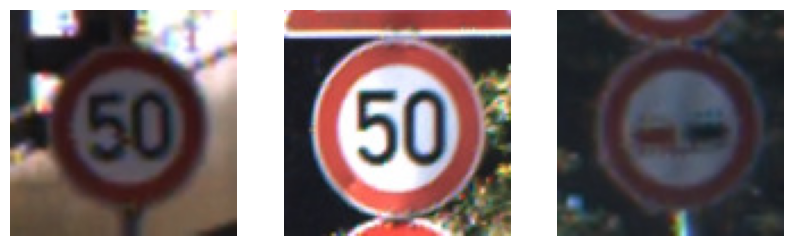

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

num_images_to_collect = 3  # Set the desired number of misclassified images to collect
max_images_to_collect = 100
misclassified_images = []

for images, labels in validation_generator:
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    misclassified_indices = np.where(predicted_labels != labels)[0]
    misclassified_images.extend(images[misclassified_indices])

    if len(misclassified_images) >= max_images_to_collect:
        break
# Randomly sample the misclassified images
selected_indices = np.random.choice(len(misclassified_images), size=num_images_to_collect, replace=False)
selected_images = [misclassified_images[i] for i in selected_indices]

plt.figure(figsize=(10, 10))
for i, image in enumerate(selected_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis("off")
plt.show()


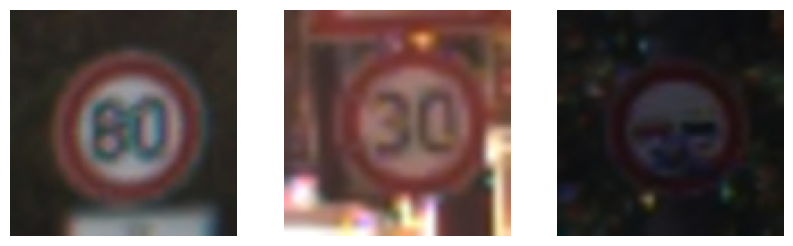

In [ ]:
selected_indices = np.random.choice(len(misclassified_images), size=num_images_to_collect, replace=False)
selected_images = [misclassified_images[i] for i in selected_indices]

plt.figure(figsize=(10, 10))
for i, image in enumerate(selected_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis("off")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_labels,predicted_labels))

In [ ]:
num_images = validation_generator.samples
print("Number of images in the generator:", num_images)

Number of images in the generator: 7841


ValueError: ignored

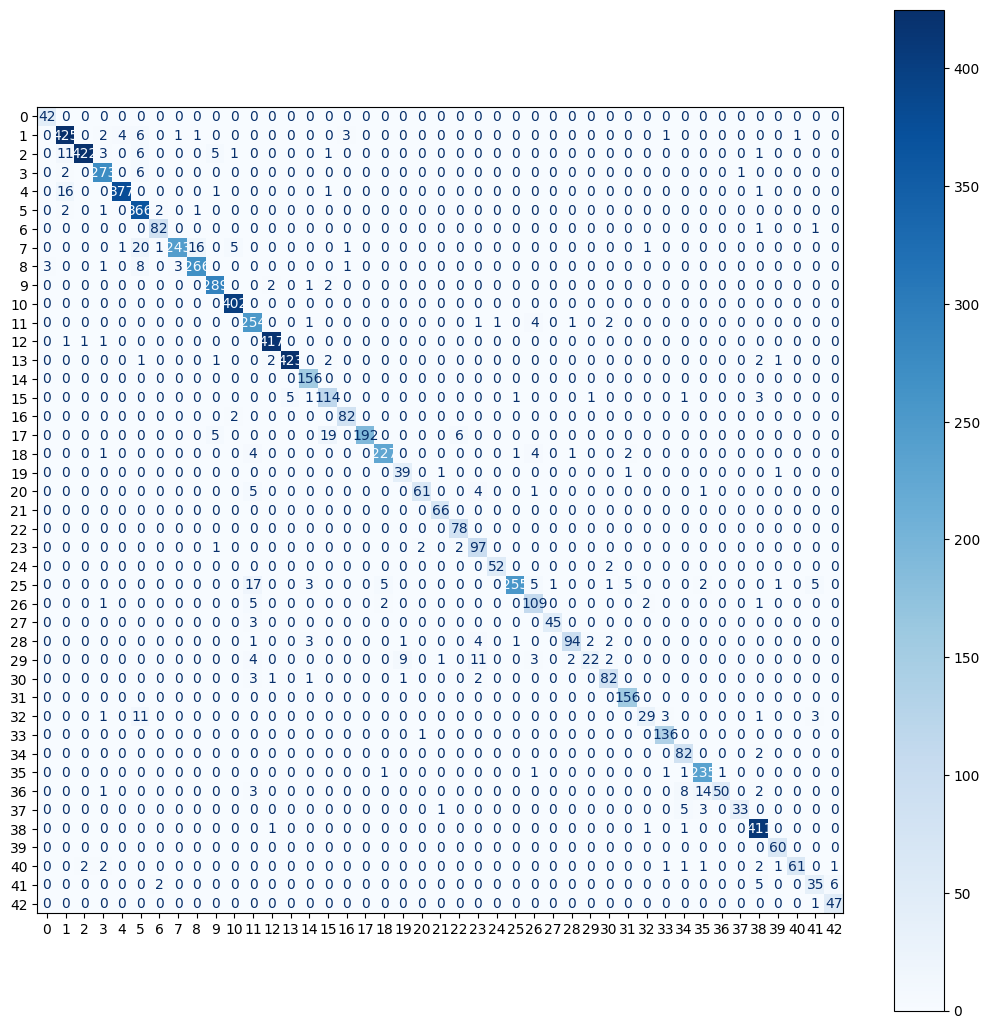

In [ ]:
from sklearn.metrics import *
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true_labels, predicted_labels)
cmd = ConfusionMatrixDisplay(cm, display_labels=predicted_labels)
fig, ax = plt.subplots(figsize=(13,13)) # For changing the size of the plot
cmd.plot(ax=ax, cmap="Blues", values_format='.5g')

## Testing the model
Once you have built and trained your model, the next step is to run the test images through it and see how well your model does at making predictions for images it has never seen before.

Since loading these images and formatting them for the model can be tricky, you may find the following code useful. This code only uses your model to predict the class label for a given image. You'll still need to compare those predictions to the "ground truth" class labels in `test_classes_partial.csv` to evaluate how well the model does.



```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test_partial'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```



In [ ]:
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test'],
        target_size=image_size,
        class_mode='categorical',
        shuffle=False)
probabilities = model.predict(test_generator)


Found 12630 images belonging to 1 classes.
395/395 [==============================] - 14s 34ms/step


In [ ]:

probabilities = model.predict(test_generator)
predicted_labels = np.argmax(probabilities, axis=1)

true_labels = test_generator.classes

395/395 [==============================] - 13s 34ms/step


In [ ]:
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.004592240696753761
Precision: 1.0
Recall: 0.004592240696753761
F1 Score: 0.00914249684741488


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_labels,predicted_labels))

##Partial Hold out Dataset
You're given the answers to the first 200 images in the hold out dataset.

Once you have predictions for the partial holdout dataset, you'll need to compare those predictions against the "ground truth" class labels in `test_classes_partial.csv` to evaluate how well the model does.

Make sure to use the insights gained from the partial hold out dataset in your executive summary.

Once you feel confident, you will need to predict for the full test dataset using the following code, and submit your csv file:

```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```

In [ ]:
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test_partial'],
        target_size=image_size,
        class_mode='categorical',
        shuffle=False)
probabilities = model.predict(test_generator)

# Load the ground truth labels from the CSV file
test_labels = pd.read_csv('test_classes_partial.csv')

# Get the predicted labels from the model
predicted_labels = [np.argmax(probas) for probas in probabilities]

# Get the true labels from the ground truth
true_labels = test_labels['ClassId'].to_list()

Found 201 images belonging to 1 classes.
7/7 [==============================] - 1s 119ms/step


In [ ]:
# Compute the metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.9253731343283582
Precision: 0.9416521841894976
Recall: 0.9253731343283582
F1 Score: 0.9214568522216042


<Figure size 1000x1000 with 0 Axes>

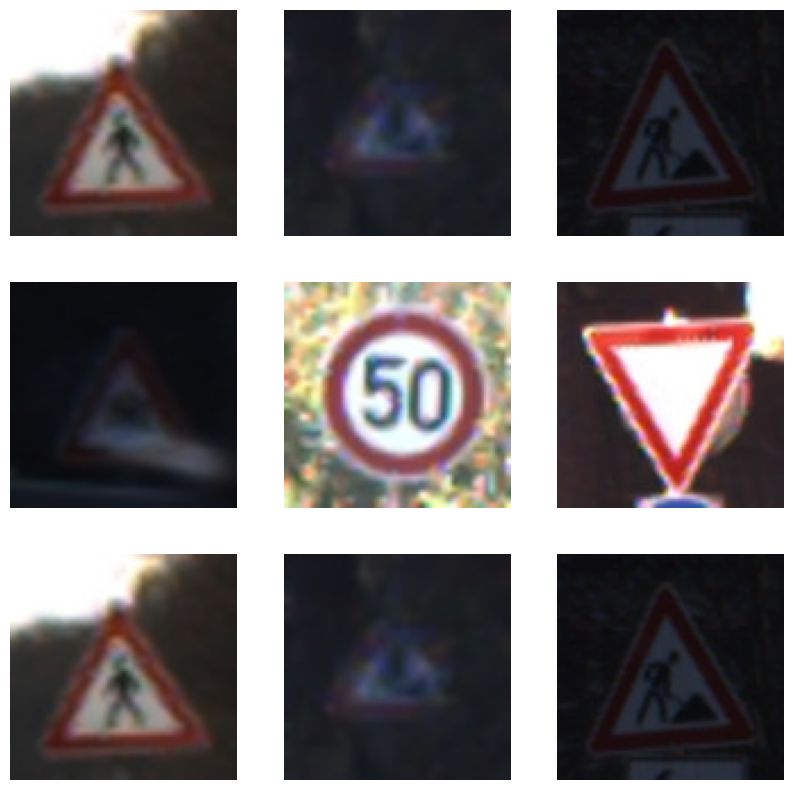

In [ ]:
plt.figure(figsize=(10, 10))
num_errors = 0
errors_list = []
for i in range(len(true_labels)):
    if true_labels[i] != predicted_labels[i]:
        errors_list.append(i)

plt.figure(figsize=(10, 10))

location = 0
for images, labels in test_generator:
    for i in errors_list:
        if location < 9 and i < len(images):
            first_image = images[i]  # Extract the image from the batch
            ax = plt.subplot(3, 3, location + 1)
            f = np.array(first_image) * 255
            plt.imshow(f.astype("uint8"))
            plt.axis("off")
            location += 1

        if location == 9 or location >= len(errors_list):
            break

    if location == 9 or location >= len(errors_list):
        break

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_labels,predicted_labels))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        11
           2       0.89      1.00      0.94         8
           3       0.67      0.80      0.73        10
           4       1.00      1.00      1.00         9
           5       0.71      1.00      0.83         5
           6       0.75      1.00      0.86         3
           7       0.89      1.00      0.94         8
           8       1.00      0.67      0.80         6
           9       1.00      1.00      1.00        10
          10       0.92      1.00      0.96        12
          11       0.73      1.00      0.84         8
          12       1.00      1.00      1.00         7
          13       1.00      1.00      1.00        10
          14       1.00      0.75      0.86         4
          15       0.67      1.00      0.80         2
          16       1.00      1.00      1.00         5
          17       1.00      1.00      1.00         7
          18       1.00    

ValueError: ignored

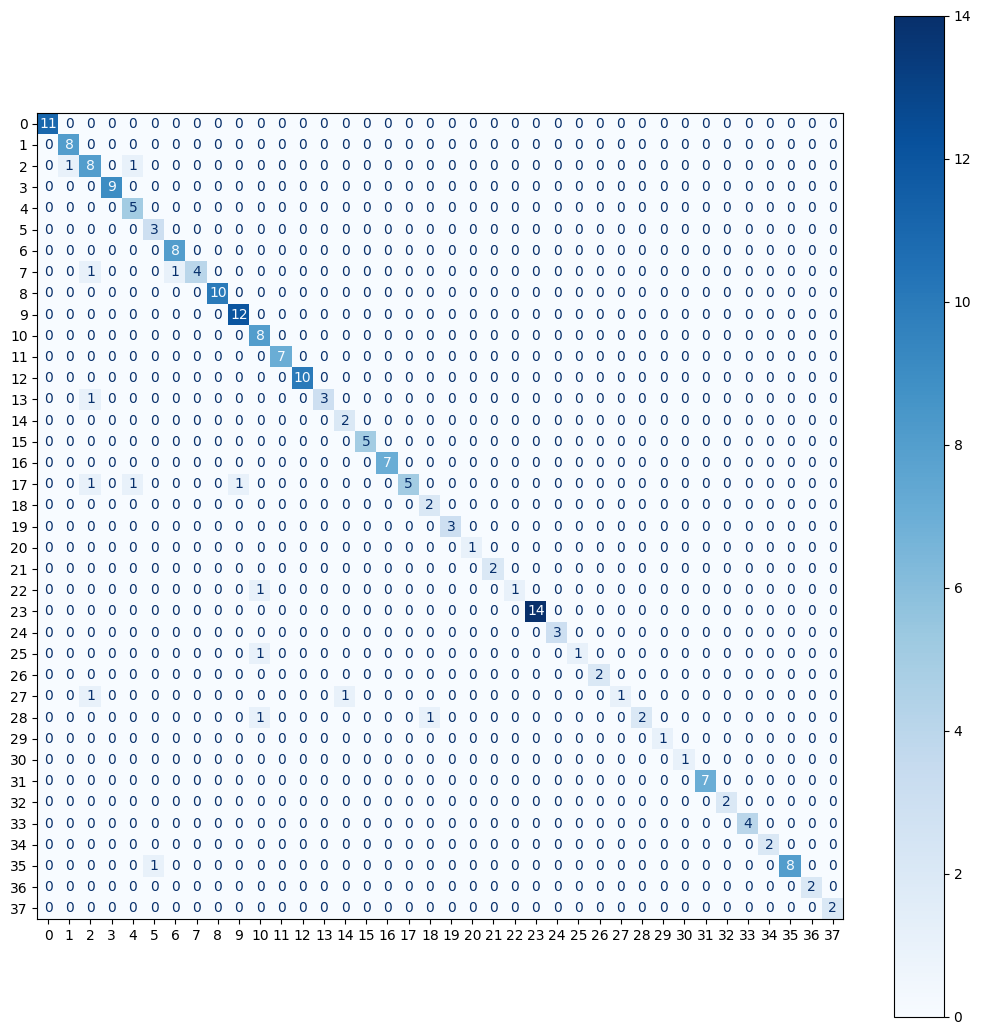

In [ ]:
from sklearn.metrics import *
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true_labels, predicted_labels)
cmd = ConfusionMatrixDisplay(cm, display_labels=predicted_labels)
fig, ax = plt.subplots(figsize=(13,13)) # For changing the size of the plot
cmd.plot(ax=ax, cmap="Blues", values_format='.5g')